In [1]:
from glotaran_tools.specification_parser import parse_yml
from glotaran_core.model import Dataset
from glotaran_models.kinetic import KineticSeperableModel
import numpy as np
from lmfit import Parameters
# Imports for plotting

import matplotlib.pyplot as plt
%matplotlib notebook

fitspec = '''
type: kinetic

parameter: {}

compartments: [s1, s2, s3]

megacomplexes:
    - label: mc1
      k_matrices: [k1]

k_matrices:
  - label: "k1"
    matrix: {{
      '("s1","s1")': 1,
      '("s2","s2")': 2,
      '("s3","s3")': 3,
}}

initial_concentrations: []

irf: []

datasets: 
  - label: dataset1
    type: spectral
    megacomplexes: [mc1]
    path: 'data/dataset1.ascii'

'''
   

In [23]:
test_parameter = [101e-4, 202e-5, 505e-6]
test_amps = [7, 3, 30]
test_x = np.arange(12820, 15120, 4.6)
times = np.asarray(np.arange(0, 500, 1.5))
simparams = Parameters()
simparams.add("p1", 101e-3)
simparams.add("p2",202e-4)
simparams.add("p3",505e-5)
simparams.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr
p1     0.101     -inf      inf     None     True     None
p2    0.0202     -inf      inf     None     True     None
p3   0.00505     -inf      inf     None     True     None


In [19]:
model = parse_yml(fitspec.format(test_parameter))

In [20]:
fitmodel = KineticSeperableModel(model)

[[  1.76233158e-026   2.06593091e-057   5.38415681e-025]
 [  2.37735342e-026   1.20915560e-056   7.91104826e-025]
 [  3.20465575e-026   6.99443687e-056   1.16087154e-024]
 ..., 
 [  3.75904716e-001   6.89634348e-306   7.68442793e-012]
 [  3.51945982e-001   1.17019724e-307   5.89872699e-012]
 [  3.29272726e-001   1.96247179e-309   4.52208631e-012]]
(334, 501)


<IPython.core.display.Javascript object>


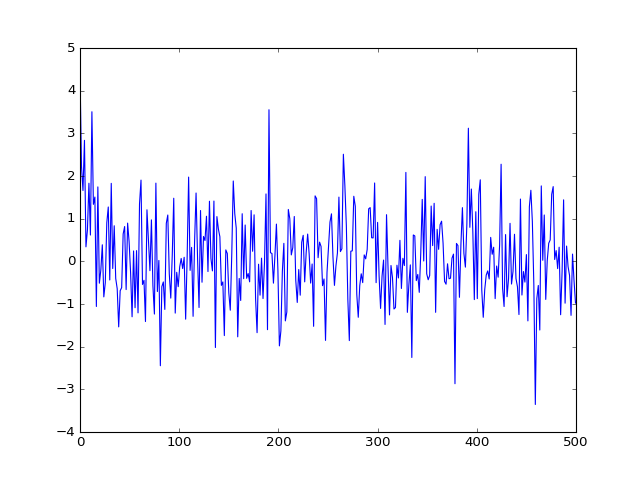

In [21]:
data = fitmodel.eval(simparams, *times, **{'dataset':'dataset1', 
                                           'noise':True, 'noise_std_dev':1,
                                           'x': test_x,
                                           'amplitudes':test_amps,
                                          'locations':[14700, 13515, 14180],
                                           'delta': [400,100,300]
                                           })
print(data.shape)
fig = plt.figure()
plt.plot(times, data[:, 300])

<IPython.core.display.Javascript object>


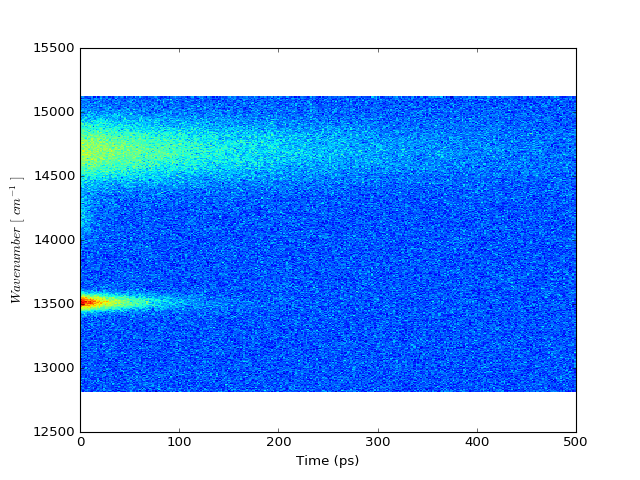

In [17]:
# Plot full trace

fig = plt.figure()
plt.xlabel('Time (ps)')
plt.ylabel('$Wavenumber\ [\ cm^{-1}\ ]$')
plt.pcolormesh(times, test_x, data.T)
plt.show()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.5991e+04                                    6.76e+05    
       1              2         8.3322e+04      2.67e+03       1.03e-02       1.60e+05    
       2              3         8.3010e+04      3.12e+02       3.98e-03       4.71e+04    
       3              4         8.2999e+04      1.08e+01       6.59e-04       4.21e+03    
       4              5         8.2997e+04      1.46e+00       6.11e-04       2.40e+03    
       5              6         8.2996e+04      1.66e+00       6.53e-04       2.67e+03    
       6              7         8.2994e+04      1.97e+00       6.94e-04       2.98e+03    
       7              8         8.2991e+04      2.38e+00       7.45e-04       3.35e+03    
       8              9         8.2989e+04      2.92e+00       8.09e-04       3.78e+03    
       9             10         8.2985e+04      3.64e+00       8.89e-04       4.28e+03    

<IPython.core.display.Javascript object>


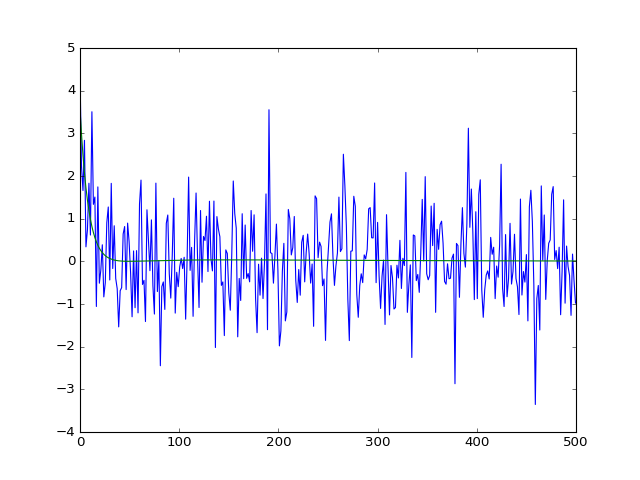

In [22]:
result = fitmodel.fit(fitmodel.get_initial_fitting_parameter(), 
                      *times, 
                      **{"data": data}
                     )
result.best_fit_parameter.pretty_print()
fitted_data = fitmodel.eval(result.best_fit_parameter, *times, **{'dataset':'dataset1','amplitudes':[50, 500, 5000]})
reconstructed_data = result.eval(*times, **{"data": data})
print('Fitted Amplitudes: {}'.format(result.e_matrix(*times, **{"data": data})))

fig = plt.figure()
plt.plot(times, data[:, 300])
# plt.plot(times, fitted_data[:, 0])
plt.plot(times, reconstructed_data[:, 300])

<IPython.core.display.Javascript object>


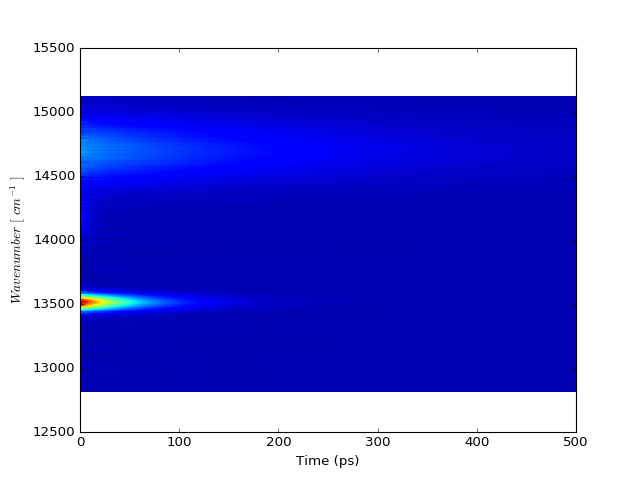

In [24]:
# Plot full trace

fig = plt.figure()
plt.xlabel('Time (ps)')
plt.ylabel('$Wavenumber\ [\ cm^{-1}\ ]$')
plt.pcolormesh(times, test_x, reconstructed_data.T)
plt.show()

In [36]:
# DAS
DAS = result.e_matrix(*times, **{"data": data})
print(DAS.shape)
print(fitmodel.compartment_map)
print(result.best_fit_parameter['p1'].value)
fig = plt.figure()
plt.plot(test_x, DAS[0, :])
plt.plot(test_x, DAS[1, :])
plt.plot(test_x, DAS[2, :])

(3, 501)


AttributeError: 'KineticSeperableModel' object has no attribute 'compartment_map'